In [62]:
import numpy as np
import matplotlib.pyplot as plt
from lib.utils import load_raw_list
import torch
from torch.nn.functional import relu,one_hot
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [69]:
X,y = load_raw_list([20])
X = X.flatten()

In [ ]:

y = one_hot(y,num_classes=3).reshape(-1,3).float()
X = X.reshape(-1,1,45000)
dataset = TensorDataset(X,y)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [48]:
from torch import nn
class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CNNLSTM, self).__init__()
        
        self.conv1 = nn.Conv1d(input_size, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.lstm1 = nn.LSTM(16, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        return x

In [51]:
model = CNNLSTM(1,2,3).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
train_losses= []

In [60]:
for epoch in range(10):
    training_loss = 0
    model.train()
    for (X,y) in dataloader:
        X,y = X.cuda(), y.cuda()
        logits = model(X)
        loss = criterion(logits,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    train_losses.append(training_loss/len(dataloader))
    print(f'Epoch {epoch} Train: {training_loss/len(dataloader)}')

Epoch 0 Train: 0.8634039238095284
Epoch 1 Train: 0.8587204366922379
Epoch 2 Train: 0.8619078546762466
Epoch 3 Train: 0.8548403233289719
Epoch 4 Train: 0.858273096382618
Epoch 5 Train: 0.8629942089319229
Epoch 6 Train: 0.8627294152975082
Epoch 7 Train: 0.862028457224369
Epoch 8 Train: 0.8579933345317841
Epoch 9 Train: 0.8498092144727707


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (3).

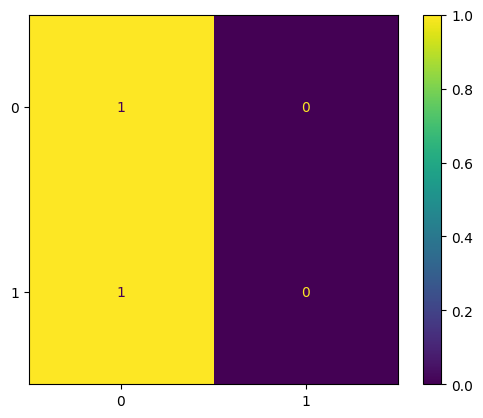

In [63]:
y_pred_logits = model(X)
sm = nn.Softmax(dim=1)
y_pred = sm(y_pred_logits).argmax(axis=1)
cm = ConfusionMatrixDisplay(confusion_matrix(y.argmax(axis=1).cpu().squeeze().cpu(),y_pred.cpu(),normalize='true'),display_labels=['P','S','W'])
cm.plot()

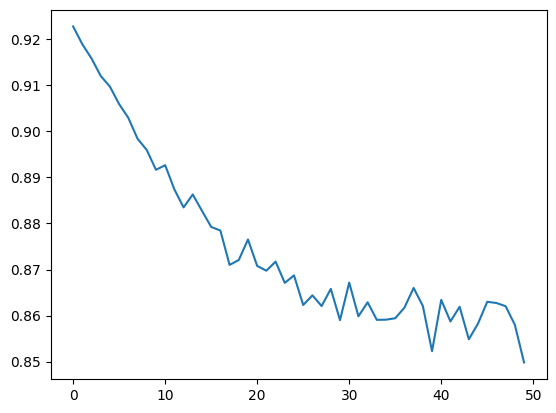

In [61]:
plt.plot(train_losses)